In [1]:
!pip install razdel

In [2]:
!pip install pymorphy2

In [3]:
!pip install pyLDAvis

In [4]:
import pandas as pd
import numpy as np
#предобработка текстов
import re
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel
from gensim.corpora.dictionary import Dictionary
import pymorphy2 
import matplotlib.pyplot as plt

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Olyad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
path = './Data/'

In [7]:
news = pd.read_csv(path+"articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [8]:
users = pd.read_csv(path+"users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### 1. Получаем векторные представления новостей

In [9]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer(  )
len(stopword_ru)

151

In [10]:
with open(path+'stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [11]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub("n", ' ', text)

    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    #print(tokens)
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
                #print(temp_cach)
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
                #print(w,' : ',temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    #print(words_lem_without_stopwords)
    return words_lem_without_stopwords

In [12]:
list(tokenize(news.iloc[0,1][:100],   ))

[Substring(0, 11, 'Заместитель'),
 Substring(12, 24, 'председателя'),
 Substring(24, 25, 'n'),
 Substring(25, 38, 'правительства'),
 Substring(39, 41, 'РФ'),
 Substring(41, 42, 'n'),
 Substring(42, 48, 'Сергей'),
 Substring(48, 49, 'n'),
 Substring(49, 55, 'Иванов'),
 Substring(55, 56, 'n'),
 Substring(56, 62, 'избран'),
 Substring(63, 76, 'председателем'),
 Substring(77, 83, 'совета'),
 Substring(83, 84, 'n'),
 Substring(84, 87, 'ПБК'),
 Substring(88, 92, 'ЦСКА'),
 Substring(92, 93, 'n'),
 Substring(93, 94, '.'),
 Substring(95, 98, 'Как'),
 Substring(99, 100, 'с')]

In [13]:
norm_text = news.iloc[:2,1].apply(lambda x: clean_text(x), 1)
norm_text

<ipython-input-11-8769e094367c>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

In [14]:
lemmatization(norm_text[0])

['заместитель',
 'председатель',
 'правительство',
 'рф',
 'сергей',
 'иванов',
 'избрать',
 'председатель',
 'совет',
 'пбк',
 'цска',
 'сообщать',
 'прессслужба',
 'армеец',
 'решение',
 'единогласно',
 'принять',
 'первый',
 'заседание',
 'совет',
 'клуб',
 'основной',
 'функция',
 'это',
 'орган',
 'обсуждение',
 'текущий',
 'состояние',
 'планирование',
 'утверждение',
 'стратегия',
 'развитие',
 'клуб',
 'близкий',
 'перспектива',
 'состав',
 'совет',
 'войти',
 'георгий',
 'полтавченко',
 'полномочный',
 'представитель',
 'президент',
 'центральный',
 'федеральный',
 'округ',
 'алексей',
 'седов',
 'генералполковник',
 'начальник',
 'служба',
 'защита',
 'конституционный',
 'строй',
 'борьба',
 'терроризм',
 'фсб',
 'рф',
 'александр',
 'новак',
 'заместитель',
 'министр',
 'финансы',
 'рф',
 'вячеслав',
 'полтавец',
 'заместитель',
 'генеральный',
 'директор',
 'руководитель',
 'блок',
 'взаимодействие',
 'орган',
 'власть',
 'социальный',
 'корпоративный',
 'политика',
 'гмк',

In [15]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 21.6 s


In [16]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 2min 55s


А теперь в 3 строчки обучим нашу модель

In [17]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [18]:
common_dictionary[4]

'банк'

In [19]:
common_dictionary.id2token

{0: 'александр',
 1: 'алексей',
 2: 'андрей',
 3: 'армеец',
 4: 'банк',
 5: 'баскетбол',
 6: 'близкий',
 7: 'блок',
 8: 'борьба',
 9: 'ватутин',
 10: 'взаимодействие',
 11: 'власть',
 12: 'войти',
 13: 'вячеслав',
 14: 'генералполковник',
 15: 'генеральный',
 16: 'георгий',
 17: 'гмк',
 18: 'директор',
 19: 'европа',
 20: 'единогласно',
 21: 'заместитель',
 22: 'заседание',
 23: 'защита',
 24: 'иванов',
 25: 'избрать',
 26: 'исакович',
 27: 'клиентский',
 28: 'клуб',
 29: 'конституционный',
 30: 'корпоративный',
 31: 'леонид',
 32: 'лопат',
 33: 'министр',
 34: 'мир',
 35: 'начальник',
 36: 'никель',
 37: 'новак',
 38: 'норильский',
 39: 'оао',
 40: 'обсуждение',
 41: 'округ',
 42: 'ольга',
 43: 'ооо',
 44: 'орган',
 45: 'основной',
 46: 'пбк',
 47: 'первый',
 48: 'перспектива',
 49: 'планирование',
 50: 'плешаков',
 51: 'политика',
 52: 'полномочный',
 53: 'полтавец',
 54: 'полтавченко',
 55: 'правительство',
 56: 'правление',
 57: 'председатель',
 58: 'представитель',
 59: 'президент

Делаем BoW по списку слов

In [20]:
common_dictionary.doc2bow(['баскетбол' ,'баскетбол' ,'баскетбол' ,'наше', 'все'], allow_update=True)

[(5, 3), (135723, 1), (135724, 1)]

In [21]:
common_corpus[0][0]

(0, 2)

In [22]:
len(texts[0])

118

Все просто - это словарь наших слов

Запускаем обучение

In [23]:
N_topic = 20 # число тем - гиперпараметр

In [24]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

Wall time: 22.7 s


In [25]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [26]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(0, 0.16895072), (5, 0.36413664), (10, 0.320451), (16, 0.12788753)]

In [27]:
x=lda.show_topics(num_topics=N_topic, num_words=15,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: украина гражданин украинский киев фронт народный законодательство это физика превысить украинец писать который юрист спасти
topic_1: который суд год погибнуть дело человек также группа город земля это результат россия апрель время
topic_2: рак восток отряд япония горный вес курение риск вода флот порт курить кг японец урожай
topic_3: газ полиция задержать экипаж польша полицейский маршрут мвд ск движение польский внедрение сближение сотрудник палата
topic_4: мозг белоруссия бизнесмен обращение еда грант берег минск медик казахстан горизонт нанести фонд отправляться русь
topic_5: это год всё который весь мочь большой очень первый человек время день ещё наш свой
topic_6: обнаружить препарат лечение фотография болезнь снизиться кровь след авария смерть кость медицинский инженер анализ год
topic_7: млн тыс год исследование пациент доход составить остров писать пенсия около составлять компания рост стоимость
topic_8: год россия ракета это эксперт российский который риск путин станц

Очень неплохо - большинство тем вполне можно описать о чем они


построим темы 

In [28]:
news['title'].iloc[5]

['ио',
 'главное',
 'тренер',
 'вячеслав',
 'буцай',
 'прокомментировать',
 'победа',
 'югра',
 'матч',
 'регулярный',
 'чемпионат',
 'кхл',
 'прежде',
 'весь',
 'хотеть',
 'поблагодарить',
 'свой',
 'ребята',
 'весь',
 'команда',
 'передавать',
 'слово',
 'официальный',
 'сайт',
 'югра',
 'игра',
 'начинаться',
 'очень',
 'удачно',
 'пропустить',
 'гол',
 'первый',
 'смена',
 'долго',
 'входить',
 'игра',
 'мочь',
 'это',
 'связать',
 'это',
 'дневный',
 'матч',
 'непривычный',
 'время',
 'плюс',
 'это',
 'третий',
 'матч',
 'сибирь',
 'гдеть',
 'ребята',
 'чувствовать',
 'скажем',
 'сонный',
 'второй',
 'третий',
 'период',
 'показать',
 'разбежаться',
 'стать',
 'играть',
 'правильно',
 'появиться',
 'момент',
 'дотерпеть',
 'считать',
 'заслуженно',
 'победить']

In [29]:
lda[common_dictionary.doc2bow(news['title'].iloc[10])]

[(0, 0.4943012),
 (6, 0.16287419),
 (7, 0.16693816),
 (14, 0.11425223),
 (18, 0.03734596)]

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [30]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [31]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.058069,0.608432,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.011788,0.125840,0.000000,0.0,0.0,0.0,0.000000,0.173241,0.016094,0.0
1,4896,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.248430,0.729047,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2,4897,0.169096,0.000000,0.000000,0.0,0.0,0.363836,0.0,0.0,0.0,...,0.320489,0.000000,0.000000,0.0,0.0,0.0,0.128005,0.000000,0.000000,0.0
3,4898,0.000000,0.000000,0.000000,0.0,0.0,0.593949,0.0,0.0,0.0,...,0.067830,0.000000,0.048518,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
4,4899,0.000000,0.000000,0.029771,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.477096,0.000000,0.0,0.0,0.0,0.000000,0.469439,0.000000,0.0


In [32]:
topic_matrix.head()

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.058069,0.608432,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.011788,0.125840,0.000000,0.0,0.0,0.0,0.000000,0.173241,0.016094,0.0
1,4896,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.248430,0.729047,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2,4897,0.169096,0.000000,0.000000,0.0,0.0,0.363836,0.0,0.0,0.0,...,0.320489,0.000000,0.000000,0.0,0.0,0.0,0.128005,0.000000,0.000000,0.0
3,4898,0.000000,0.000000,0.000000,0.0,0.0,0.593949,0.0,0.0,0.0,...,0.067830,0.000000,0.048518,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
4,4899,0.000000,0.000000,0.029771,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.477096,0.000000,0.0,0.0,0.0,0.000000,0.469439,0.000000,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [33]:
users.head(10)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"
5,u106662,"[323868, 323426, 324267, 322426, 324104, 1550]"
6,u105949,"[293138, 294471, 295012, 294736, 293949, 3544]"
7,u102457,"[6928, 5009, 6940, 7629, 7644, 512736]"
8,u104124,"[322838, 324699, 322991, 322120, 324327, 472331]"
9,u101386,"[7827, 6427, 7394, 7151, 6335, 487254]"


In [34]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topic)]].values))

In [35]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.        , 0.01790134,
       0.1670154 , 0.03445571, 0.02242166, 0.19338818, 0.        ,
       0.        , 0.24112912, 0.10986524, 0.03702739, 0.01559599,
       0.07029881, 0.08426338, 0.        , 0.        , 0.        ])

In [36]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    user_vector1 = np.max(user_vector, 0)  # можно не средний
    return user_vector1 #,user_vector

In [37]:
user_articles_list = users['articles'].iloc[33]

In [38]:
vv = get_user_embedding(user_articles_list)
vv

array([0.03084925, 0.45598993, 0.07159683, 0.03983313, 0.        ,
       0.17974101, 0.        , 0.08641332, 0.36032784, 0.35148355,
       0.03181045, 0.35349959, 0.29394904, 0.07824773, 0.        ,
       0.09630883, 0.10327084, 0.34162369, 0.01981124, 0.        ])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [39]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.572729,0.233365,0.024705,0.016667,0.017901,0.167015,0.034456,0.025980,0.310778,...,0.111763,0.518828,0.308071,0.039062,0.015912,0.070299,0.268291,0.120379,0.0,0.000000
1,u108690,0.247396,0.129632,0.000000,0.063677,0.000000,0.135531,0.050249,0.098944,0.163132,...,0.000000,0.335086,0.376006,0.018402,0.000000,0.084687,0.153379,0.234371,0.0,0.016214
2,u108339,0.042400,0.253684,0.108750,0.093932,0.014224,0.083991,0.019568,0.032587,0.049708,...,0.027097,0.412103,0.268190,0.050544,0.000000,0.075652,0.151290,0.212787,0.0,0.069881


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [40]:
target = pd.read_csv(path+"users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [41]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.572729,0.233365,0.024705,0.016667,0.017901,0.167015,0.034456,0.025980,0.310778,...,0.518828,0.308071,0.039062,0.015912,0.070299,0.268291,0.120379,0.0,0.000000,0
1,u108690,0.247396,0.129632,0.000000,0.063677,0.000000,0.135531,0.050249,0.098944,0.163132,...,0.335086,0.376006,0.018402,0.000000,0.084687,0.153379,0.234371,0.0,0.016214,1
2,u108339,0.042400,0.253684,0.108750,0.093932,0.014224,0.083991,0.019568,0.032587,0.049708,...,0.412103,0.268190,0.050544,0.000000,0.075652,0.151290,0.212787,0.0,0.069881,1


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [43]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=0, test_size=0.25)

In [44]:
logreg = LogisticRegression(C=1.0)
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [45]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.2253908 , 0.01888645, 0.56580606, 0.00776285, 0.07118766,
       0.13638866, 0.02241726, 0.43155533, 0.00752796, 0.04623406])

In [46]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [47]:

precision, recall, thresholds = precision_recall_curve(y_test.values, preds)


In [48]:
n=-1
fscore = (2 * precision[:n] * recall[:n]) / (precision[:n] + recall[:n])

# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.311299, F-Score=0.758, Precision=0.721, Recall=0.800


In [49]:
roc_auc= roc_auc_score(y_test, preds)
roc_auc

0.9657794057794057

In [50]:
metrics_list=[]
embedding_max = ['max', format(thresholds[ix], ".3f"), format(fscore[ix], ".3f"), format(precision[ix],".3f"), format(recall[ix], ".3f"), roc_auc]
embedding_max

['max', '0.311', '0.758', '0.721', '0.800', 0.9657794057794057]

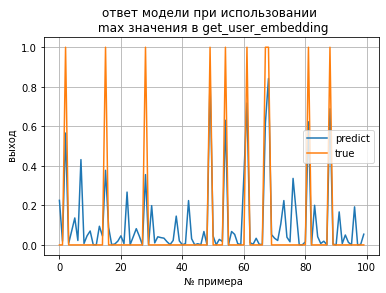

In [51]:
plt.plot( preds[:100], label = 'predict')
plt.plot(y_test.values[:100], label = 'true')
plt.title('ответ модели при использовании \n max значения в get_user_embedding')
plt.xlabel(' № примера')
plt.ylabel(' выход')
plt.legend()
plt.grid('On')
plt.show()

## использование медианы в embedding

In [52]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    user_vector1 = np.median(user_vector, 0)  # можно не средний
    return user_vector1 #,user_vector

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [53]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.114817,...,0.0,0.205629,0.164228,0.000000,0.0,0.0,0.081676,0.000000,0.0,0.000000
1,u108690,0.048728,0.047229,0.0,0.000000,0.0,0.005802,0.0,0.0,0.040909,...,0.0,0.197783,0.251727,0.000000,0.0,0.0,0.048615,0.131450,0.0,0.000000
2,u108339,0.000000,0.178083,0.0,0.010523,0.0,0.000000,0.0,0.0,0.018099,...,0.0,0.245449,0.128232,0.005543,0.0,0.0,0.030373,0.096394,0.0,0.005023


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [54]:
target = pd.read_csv(path+"users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [55]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.114817,...,0.205629,0.164228,0.000000,0.0,0.0,0.081676,0.000000,0.0,0.000000,0
1,u108690,0.048728,0.047229,0.0,0.000000,0.0,0.005802,0.0,0.0,0.040909,...,0.197783,0.251727,0.000000,0.0,0.0,0.048615,0.131450,0.0,0.000000,1
2,u108339,0.000000,0.178083,0.0,0.010523,0.0,0.000000,0.0,0.0,0.018099,...,0.245449,0.128232,0.005543,0.0,0.0,0.030373,0.096394,0.0,0.005023,1


In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [57]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=0, test_size=0.25)

In [58]:
logreg = LogisticRegression(C=1.0)
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [59]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.30110343, 0.1091184 , 0.59567467, 0.40741139, 0.00832416,
       0.03241971, 0.04897828, 0.17141834, 0.04805823, 0.09780677])

In [60]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [61]:

precision, recall, thresholds = precision_recall_curve(y_test.values, preds)


In [62]:
n=-1
fscore = (2 * precision[:n] * recall[:n]) / (precision[:n] + recall[:n])

# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.276106, F-Score=0.684, Precision=0.625, Recall=0.755


In [63]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.954192685621257

In [64]:
embedding_median = ['mediana', format(thresholds[ix], ".3f"), format(fscore[ix], ".3f"), format(precision[ix],".3f"), format(recall[ix], ".3f"), roc_auc]
embedding_median

['mediana', '0.276', '0.684', '0.625', '0.755', 0.954192685621257]

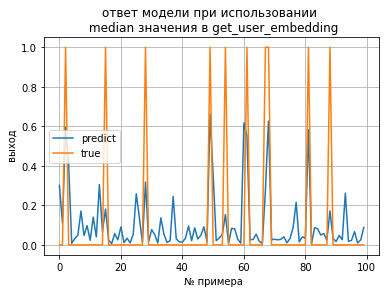

In [65]:
plt.plot( preds[:100], label = 'predict')
plt.plot(y_test.values[:100], label = 'true')
plt.title('ответ модели при использовании \n median значения в get_user_embedding')
plt.xlabel(' № примера')
plt.ylabel(' выход')
plt.legend()
plt.grid('On')
plt.show()

## Использование mean в get_user_embedding

In [66]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    user_vector1 = np.mean(user_vector, 0)  # можно не средний
    return user_vector1 #,user_vector

In [67]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.098721,0.038894,0.004117,0.002778,0.002984,0.030386,0.005743,0.008067,0.122300,...,0.018627,0.244119,0.159003,0.012682,0.005251,0.020217,0.103730,0.020063,0.0,0.000000
1,u108690,0.079407,0.058181,0.000000,0.016222,0.000000,0.039752,0.015694,0.021551,0.067924,...,0.000000,0.194826,0.217404,0.003067,0.000000,0.026917,0.057703,0.143030,0.0,0.005179
2,u108339,0.009835,0.189732,0.018125,0.022739,0.002371,0.017164,0.006319,0.008486,0.018690,...,0.004516,0.249190,0.157554,0.013261,0.000000,0.012609,0.053103,0.088398,0.0,0.020423


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [68]:
target = pd.read_csv(path+"users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [69]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.098721,0.038894,0.004117,0.002778,0.002984,0.030386,0.005743,0.008067,0.122300,...,0.244119,0.159003,0.012682,0.005251,0.020217,0.103730,0.020063,0.0,0.000000,0
1,u108690,0.079407,0.058181,0.000000,0.016222,0.000000,0.039752,0.015694,0.021551,0.067924,...,0.194826,0.217404,0.003067,0.000000,0.026917,0.057703,0.143030,0.0,0.005179,1
2,u108339,0.009835,0.189732,0.018125,0.022739,0.002371,0.017164,0.006319,0.008486,0.018690,...,0.249190,0.157554,0.013261,0.000000,0.012609,0.053103,0.088398,0.0,0.020423,1


In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [71]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=0, test_size=0.25)

In [72]:
logreg = LogisticRegression(C=1.0)
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [73]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.11733874, 0.06444423, 0.54941274, 0.24901027, 0.00682277,
       0.02916364, 0.07355761, 0.12492726, 0.01337971, 0.07694941])

In [74]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [75]:

precision, recall, thresholds = precision_recall_curve(y_test.values, preds)


In [76]:
n=-1
fscore = (2 * precision[:n] * recall[:n]) / (precision[:n] + recall[:n])

# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.263720, F-Score=0.680, Precision=0.600, Recall=0.784


In [77]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9497877783592069

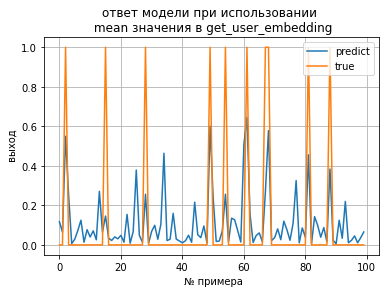

In [78]:
plt.plot( preds[:100], label = 'predict')
plt.plot(y_test.values[:100], label = 'true')
plt.title('ответ модели при использовании \n mean значения в get_user_embedding')
plt.xlabel(' № примера')
plt.ylabel(' выход')
plt.legend()
plt.grid('On')
plt.show()

In [79]:

embedding_mean = ['mean', format(thresholds[ix], ".3f"), format(fscore[ix], ".3f"), format(precision[ix],".3f"), format(recall[ix], ".3f"), roc_auc]
embedding_mean
metrics_list.append(embedding_max), metrics_list.append(embedding_median), metrics_list.append(embedding_mean)

(None, None, None)

In [80]:
metrics_list = pd.DataFrame(metrics_list, columns=['type', 'Best Threshold', 'F-Score', 'Precision', 'Recall', 'roc_auc'])

In [81]:
metrics_list.head()

,type,Best Threshold,F-Score,Precision,Recall,roc_auc
0,max,0.311,0.758,0.721,0.800,0.965779
1,mediana,0.276,0.684,0.625,0.755,0.954193
2,mean,0.264,0.680,0.600,0.784,0.949788


**Выводы:** *По результатам обучения модели с разными методами embedding-а можем сделать вывод, что лучше всех себя показала первая моделька с использованием максимального значения всех векторов из пространства статей, качество такой модели по всем метрикам выше чем у остальных методов ee roc_auc составляет: 0.966.*